## 쇼핑몰 지점별 매출액 예측 (Dacon)
#### 쇼핑몰의 프로모션, 주변 기온, 휴일 정보 등을 이용한 지점별 한 달 매출액 예측

## 라이브러리 및 데이터 로드

In [1]:
import optuna
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import mean_squared_error

df=pd.read_csv('../input/example-data/weekly_sales_train.csv',encoding='utf-8')
test=pd.read_csv('../input/example-data/weekly_sales_test.csv',encoding='utf-8')
df.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


## EDA

In [2]:
df.info()

# Date, IsHoliday 컬럼 변환

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


In [3]:
# Train 데이터 Date, IsHoliday 컬럼 변환
df['Date']=pd.to_datetime(df['Date'])
df['Day']=df['Date'].dt.day
df['Month']=df['Date'].dt.month
df['Year']=df['Date'].dt.year
df['IsHoliday']=df['IsHoliday'].astype('int64')

df.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Day,Month,Year
0,1,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,0,1643690.90,2,5,2010
1,2,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,1,1641957.44,2,12,2010
2,3,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,0,1611968.17,19,2,2010
3,4,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,0,1409727.59,26,2,2010
4,5,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,0,1554806.68,3,5,2010


In [4]:
# test 데이터 Date, IsHoliday 컬럼 변환
test['Date']=pd.to_datetime(test['Date'])
test['Day']=test['Date'].dt.day
test['Month']=test['Date'].dt.month
test['Year']=test['Date'].dt.year
test['IsHoliday']=test['IsHoliday'].astype('int64')

test.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Day,Month,Year
0,1,1,2012-05-10,68.55,3.617,8077.89,NaN,18.22,3617.43,3626.14,6.573,0,10,5,2012
1,2,1,2012-12-10,62.99,3.601,2086.18,NaN,8.11,602.36,5926.45,6.573,0,10,12,2012
2,3,1,2012-10-19,67.97,3.594,950.33,NaN,4.93,80.25,2312.85,6.573,0,19,10,2012
3,4,1,2012-10-26,69.16,3.506,2585.85,31.75,6.00,1057.16,1305.01,6.573,0,26,10,2012
4,5,2,2012-05-10,70.27,3.617,6037.76,NaN,10.04,3027.37,3853.40,6.170,0,10,5,2012


In [5]:
df.shape, test.shape

((6255, 16), (180, 15))

In [6]:
# 결측값 확인
print(df.isnull().sum())
print(test.isnull().sum())

id                 0
Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4153
Promotion2      4663
Promotion3      4370
Promotion4      4436
Promotion5      4140
Unemployment       0
IsHoliday          0
Weekly_Sales       0
Day                0
Month              0
Year               0
dtype: int64
id                0
Store             0
Date              0
Temperature       0
Fuel_Price        0
Promotion1        2
Promotion2      135
Promotion3       19
Promotion4       34
Promotion5        0
Unemployment      0
IsHoliday         0
Day               0
Month             0
Year              0
dtype: int64


In [7]:
df.describe()

,id,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Day,Month,Year
count,6255.000000,6255.000000,6255.000000,6255.000000,2102.000000,1592.000000,1885.000000,1819.000000,2115.000000,6255.000000,6255.000000,6.255000e+03,6255.000000,6255.000000,6255.000000
mean,3128.000000,23.000000,60.639199,3.344369,7155.930661,3308.125810,1462.535523,3465.952501,4518.993173,8.029236,0.071942,1.047619e+06,15.633094,6.395683,2010.935252
std,1805.807299,12.988211,18.624094,0.455364,8408.206085,9382.823804,9667.580258,6413.116294,6048.661908,1.874875,0.258413,5.654362e+05,8.804843,3.306284,0.788547
min,1.000000,1.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.410000,135.160000,4.077000,0.000000,2.099862e+05,1.000000,1.000000,2010.000000
25%,1564.500000,12.000000,47.170000,2.917000,1844.295000,39.755000,4.700000,499.895000,1742.305000,6.916500,0.000000,5.538695e+05,8.000000,4.000000,2010.000000
50%,3128.000000,23.000000,62.720000,3.413000,5221.140000,205.410000,24.600000,1532.630000,3226.410000,7.906000,0.000000,9.604761e+05,16.000000,6.000000,2011.000000
75%,4691.500000,34.000000,75.220000,3.722000,9199.242500,1931.005000,104.010000,3640.905000,5444.030000,8.622000,0.000000,1.421209e+06,23.000000,9.000000,2012.000000
max,6255.000000,45.000000,100.140000,4.308000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,14.313000,1.000000,3.818686e+06,31.000000,12.000000,2012.000000


In [8]:
test.describe()

,id,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Day,Month,Year
count,180.000000,180.0000,180.000000,180.000000,178.000000,45.000000,161.000000,146.000000,180.000000,180.000000,180.0,180.000000,180.000000,180.0
mean,90.500000,23.0000,61.518056,3.853361,3308.837584,64.672000,30.557888,1284.340068,3451.423778,6.953711,0.0,16.250000,9.250000,2012.0
std,52.105662,13.0234,10.455740,0.274645,3054.767656,68.190071,47.713744,1565.140023,2878.242354,1.593834,0.0,6.740916,2.593234,0.0
min,1.000000,1.0000,39.380000,3.494000,15.880000,-7.010000,0.010000,0.220000,180.070000,3.879000,0.0,10.000000,5.000000,2012.0
25%,45.750000,12.0000,54.180000,3.601000,968.205000,7.240000,4.700000,372.817500,1310.800000,6.034000,0.0,10.000000,8.750000,2012.0
50%,90.500000,23.0000,61.530000,3.789000,2352.585000,53.070000,9.890000,727.930000,2805.300000,6.895000,0.0,14.500000,10.000000,2012.0
75%,135.250000,34.0000,70.357500,4.027000,5028.902500,101.340000,28.910000,1507.197500,4471.612500,8.000000,0.0,20.750000,10.500000,2012.0
max,180.000000,45.0000,85.180000,4.468000,16670.040000,364.570000,250.600000,9546.750000,15387.940000,10.199000,0.0,26.000000,12.000000,2012.0


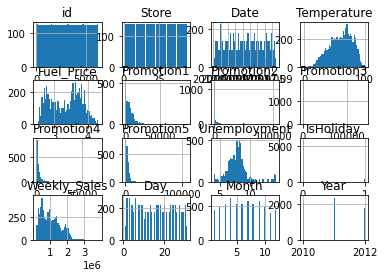

In [9]:
df.hist(bins=50);
# Store값 확인 필요

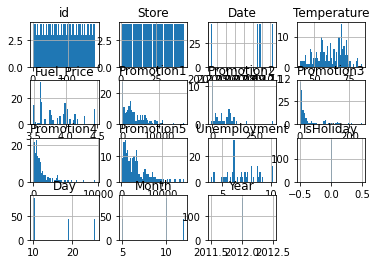

In [10]:
test.hist(bins=50);

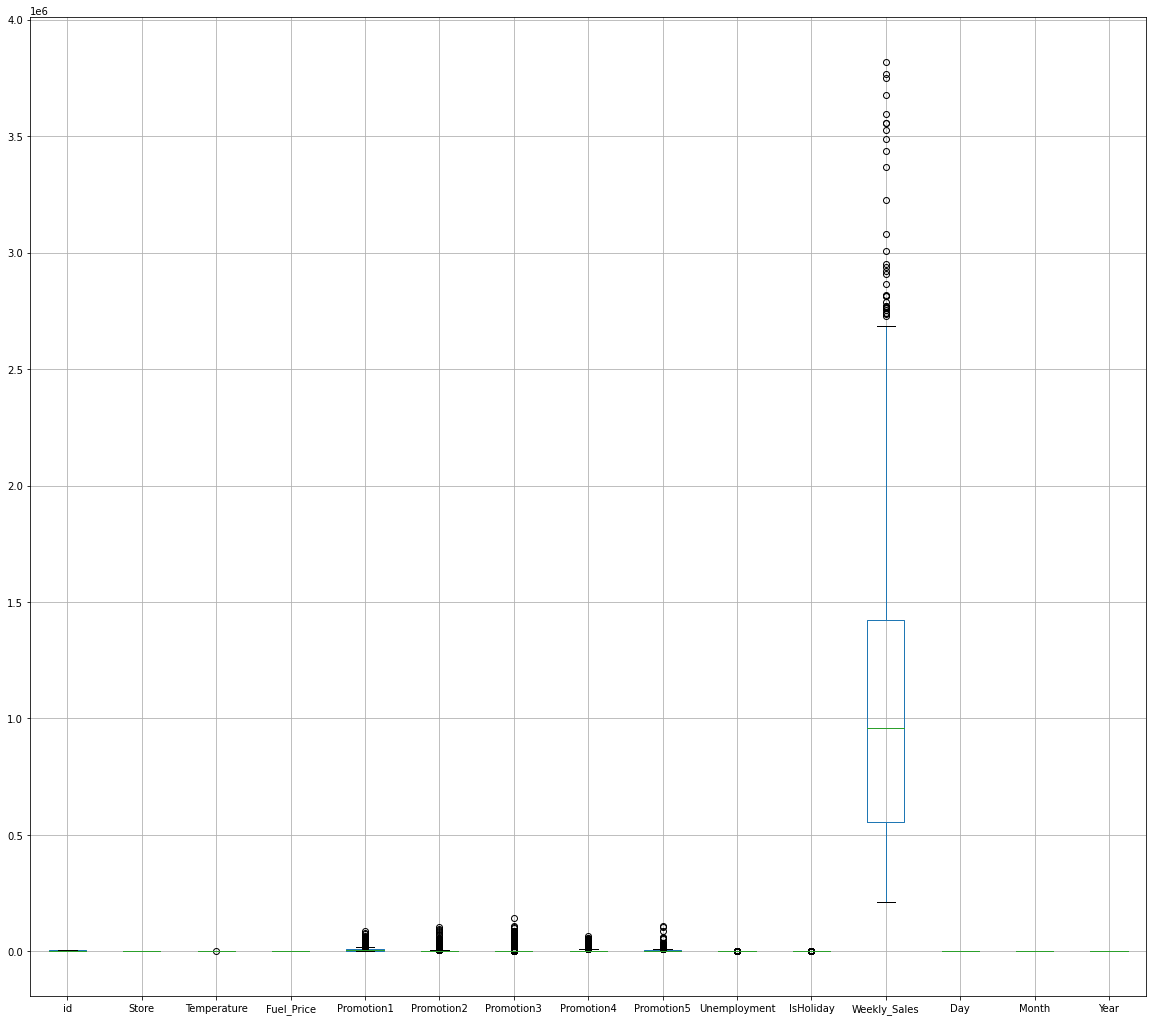

In [11]:
df.boxplot(figsize=(20,18));
# 특별한 이상값은 없어보임

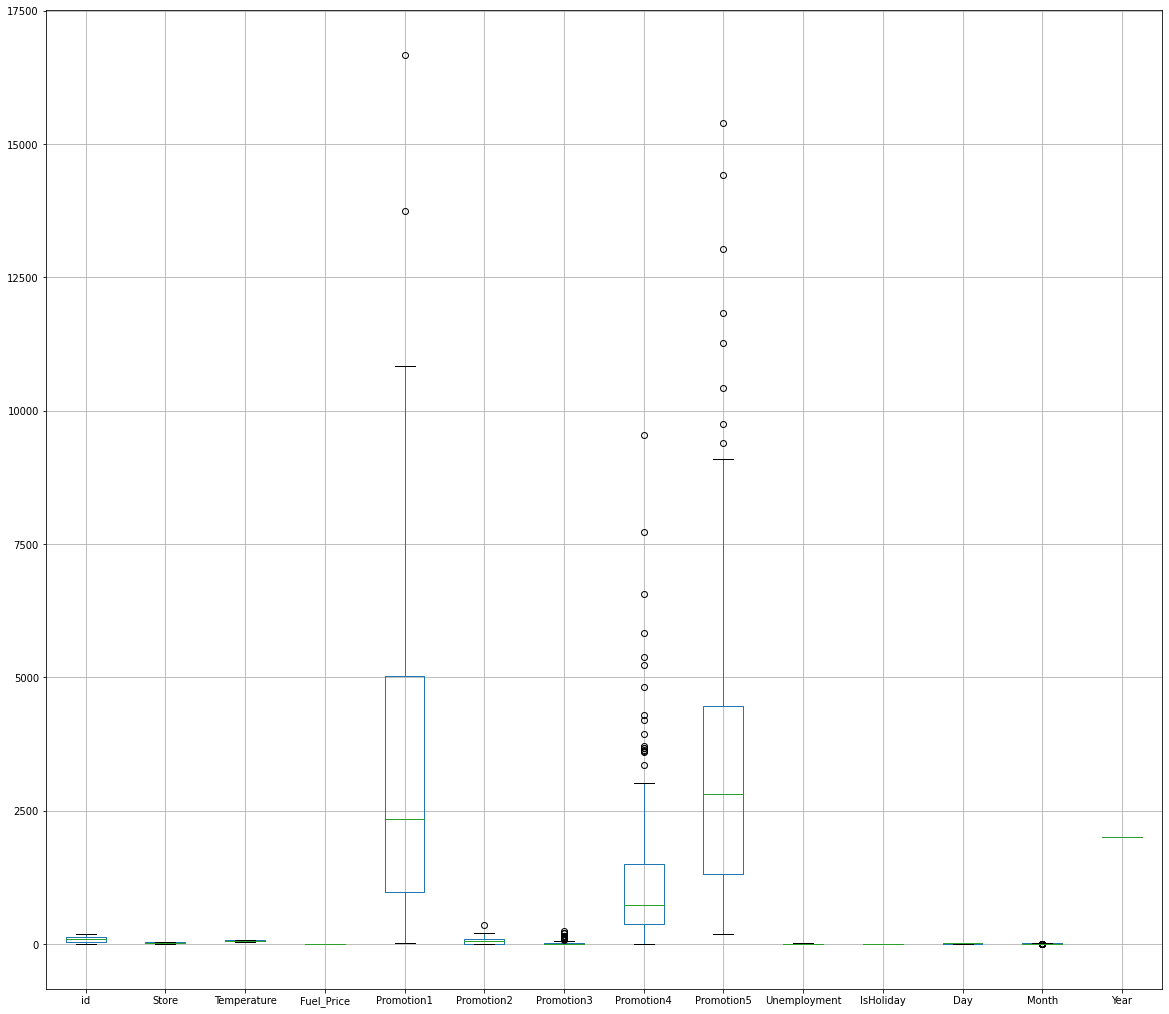

In [12]:
test.boxplot(figsize=(20,18));

In [13]:
df['Store'].value_counts()

1     139
24    139
26    139
27    139
28    139
29    139
30    139
31    139
32    139
33    139
34    139
35    139
36    139
37    139
38    139
39    139
40    139
41    139
42    139
43    139
44    139
25    139
23    139
2     139
22    139
3     139
4     139
5     139
6     139
7     139
8     139
9     139
10    139
11    139
12    139
13    139
14    139
15    139
16    139
17    139
18    139
19    139
20    139
21    139
45    139
Name: Store, dtype: int64

In [14]:
test['Store'].value_counts()

1     4
24    4
26    4
27    4
28    4
29    4
30    4
31    4
32    4
33    4
34    4
35    4
36    4
37    4
38    4
39    4
40    4
41    4
42    4
43    4
44    4
25    4
23    4
2     4
22    4
3     4
4     4
5     4
6     4
7     4
8     4
9     4
10    4
11    4
12    4
13    4
14    4
15    4
16    4
17    4
18    4
19    4
20    4
21    4
45    4
Name: Store, dtype: int64

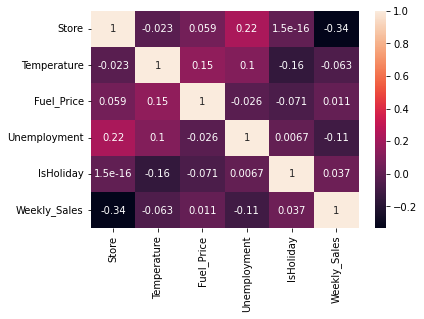

In [15]:
# Store, Temperature, Fuel_Price, Unemployment, IsHoliday, Weekly_Sales 상관관계 확인
sns.heatmap(df[['Store', 'Temperature', 'Fuel_Price', 'Unemployment', 'IsHoliday', 'Weekly_Sales']].corr(), annot=True);

## 전처리

In [16]:
# 데이터 분리
y=df[['Weekly_Sales']]
x=df.drop(columns=['id','Date','Weekly_Sales'])
test_id=test['id']
test=test.drop(columns=['id','Date'])

x.shape, y.shape, test.shape

((6255, 13), (6255, 1), (180, 13))

In [17]:
# 결측값 처리
# 프로모션 결측값은 프로모션이 없었을 것으로 추측하여 0으로 채우기
cols=[c for c in x.columns]
for i in cols:
    x[i]=x[i].fillna(0)
    test[i]=test[i].fillna(0)
    
print(x.isnull().sum())
print(test.isnull().sum())

Store           0
Temperature     0
Fuel_Price      0
Promotion1      0
Promotion2      0
Promotion3      0
Promotion4      0
Promotion5      0
Unemployment    0
IsHoliday       0
Day             0
Month           0
Year            0
dtype: int64
Store           0
Temperature     0
Fuel_Price      0
Promotion1      0
Promotion2      0
Promotion3      0
Promotion4      0
Promotion5      0
Unemployment    0
IsHoliday       0
Day             0
Month           0
Year            0
dtype: int64


In [18]:
# 정규화
scale=MinMaxScaler()
x_train=scale.fit_transform(x)
x_test=scale.transform(test)

In [19]:
# 검증 데이터 분할
x_tr, x_val, y_tr, y_val=train_test_split(x_train,y,random_state=2022,test_size=0.2)
x_tr.shape,x_val.shape,y_tr.shape,y_val.shape

((5004, 13), (1251, 13), (5004, 1), (1251, 1))

## 모델 적용

In [20]:
# 모델 적용
cb=CatBoostRegressor()
svr=SVR(kernel='poly')
rf=RandomForestRegressor(random_state=2022)
lr=LinearRegression()
xgb=XGBRegressor();
lgbm=LGBMRegressor();
knn=KNeighborsRegressor()

stack=StackingCVRegressor(regressors=(cb,rf,xgb,lgbm,lr),meta_regressor=knn,
                          random_state=2022)
stack.fit(x_tr, y_tr)
pred_test=stack.predict(x_val)

Learning rate set to 0.050975
0:	learn: 558110.1126482	total: 59.5ms	remaining: 59.5s
1:	learn: 549882.4774237	total: 62.5ms	remaining: 31.2s
2:	learn: 543030.4820600	total: 65.1ms	remaining: 21.6s
3:	learn: 535903.6635362	total: 68.1ms	remaining: 16.9s
4:	learn: 529191.1606174	total: 70.6ms	remaining: 14.1s
5:	learn: 522990.0229429	total: 73.8ms	remaining: 12.2s
6:	learn: 515443.5344168	total: 76.4ms	remaining: 10.8s
7:	learn: 509166.6726322	total: 79.5ms	remaining: 9.86s
8:	learn: 503980.3194500	total: 82ms	remaining: 9.03s
9:	learn: 495601.5772761	total: 84.4ms	remaining: 8.36s
10:	learn: 491900.5535154	total: 86.6ms	remaining: 7.79s
11:	learn: 486387.8959267	total: 89ms	remaining: 7.32s
12:	learn: 479838.5730846	total: 91.4ms	remaining: 6.94s
13:	learn: 475609.6091530	total: 93.6ms	remaining: 6.59s
14:	learn: 472460.4100108	total: 96.5ms	remaining: 6.33s
15:	learn: 469750.9696580	total: 99.2ms	remaining: 6.1s
16:	learn: 465485.4308234	total: 102ms	remaining: 5.87s
17:	learn: 461659

## 기본 모델 평가

In [21]:
# 평가(Meta-KNN)
rmse=np.sqrt(mean_squared_error(y_val,pred_test))
rmse

76797.9305105739

## 하이퍼파라미터 튜닝

In [22]:
# lgbm 튜닝
def objective(trial,data=x_train,target=y):
    
    param = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)
    
    model.fit(x_tr,y_tr,eval_set=[(x_val,y_val)], verbose=0, early_stopping_rounds= 100)
    preds = model.predict(x_val)
    rmse = mean_squared_error(y_val, preds,squared=False)
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

lgbm = LGBMRegressor(**study.best_params) 

[I 2022-07-17 08:13:00,994] A new study created in memory with name: no-name-2352c4c9-0d4b-411f-aec3-47af88f1f165
[I 2022-07-17 08:13:31,915] Trial 0 finished with value: 95084.43265401038 and parameters: {'reg_alpha': 0.5302094212754245, 'reg_lambda': 1.6833470601367075, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 742, 'min_child_samples': 122, 'min_data_per_groups': 56}. Best is trial 0 with value: 95084.43265401038.
[I 2022-07-17 08:14:14,036] Trial 1 finished with value: 147516.80783849795 and parameters: {'reg_alpha': 0.09066523548418624, 'reg_lambda': 0.0014092293411305998, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 719, 'min_child_samples': 245, 'min_data_per_groups': 3}. Best is trial 0 with value: 95084.43265401038.
[I 2022-07-17 08:14:41,763] Trial 2 finished with value: 96946.67571726585 and parameters: {'reg_alpha': 0.003283151034315003, 'reg_lambda': 0.0205515389184

Number of finished trials: 50
Best trial: {'reg_alpha': 0.6576984180232568, 'reg_lambda': 0.13038233767808255, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 810, 'min_child_samples': 21, 'min_data_per_groups': 15}


In [23]:
# rf 튜닝
def objective(trial,data=x_train,target=y):
    
    param = {
        'max_depth':trial.suggest_int('max_depth', 3,30), 
        'min_samples_split':trial.suggest_int('min_samples_split',2, 20), 
        'min_samples_leaf':trial.suggest_int('min_samples_leaf',1, 10),
        'max_samples':trial.suggest_int('max_samples',1,10),
        'n_estimators':trial.suggest_categorical('n_estimators', [100,200,300,400,500]),
        'max_features':trial.suggest_categorical('max_features',['auto','log2']),
        'random_state':2022
    }
    model = RandomForestRegressor(**param)
    
    model.fit(x_tr,y_tr)
    preds = model.predict(x_val)
    rmse = mean_squared_error(y_val, preds,squared=False)
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

rf = RandomForestRegressor(**study.best_params)

[I 2022-07-17 08:51:35,224] A new study created in memory with name: no-name-0ebea5c4-dae1-4c28-852e-cf60c27b71d8
[I 2022-07-17 08:51:35,524] Trial 0 finished with value: 569058.6208388914 and parameters: {'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_samples': 1, 'n_estimators': 100, 'max_features': 'auto'}. Best is trial 0 with value: 569058.6208388914.
[I 2022-07-17 08:51:35,712] Trial 1 finished with value: 569407.2103848757 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 5, 'n_estimators': 100, 'max_features': 'auto'}. Best is trial 0 with value: 569058.6208388914.
[I 2022-07-17 08:51:37,579] Trial 2 finished with value: 569079.4125534554 and parameters: {'max_depth': 25, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_samples': 3, 'n_estimators': 500, 'max_features': 'log2'}. Best is trial 0 with value: 569058.6208388914.
[I 2022-07-17 08:51:38,498] Trial 3 finished with value: 569194.2101439065 and parame

Number of finished trials: 50
Best trial: {'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 10, 'n_estimators': 200, 'max_features': 'auto'}


In [24]:
# knn 튜닝
param={'n_neighbors':randint(low=1, high=50)}
cv=RandomizedSearchCV(knn, param_distributions=param,
                      cv=5, n_iter=50, n_jobs = -1)
cv.fit(x_train,y)
print('Best Parameter :', cv.best_params_)
print('Best Score :', round(cv.best_score_, 4))

Best Parameter : {'n_neighbors': 48}
Best Score : -0.1582


In [25]:
# xgb 튜닝
def objective(trial,data=x_train,target=y):
    
    param = {
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_int('max_depth', 3,30),
        'min_child_weight': trial.suggest_categorical('min_child_weight', [1, 3, 5]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'n_estimators' : trial.suggest_categorical('n_estimators', [100,200,300,400,500]),
        'objective': trial.suggest_categorical('objective', ['reg:squarederror'])
    }
    model = XGBRegressor(**param)
    
    model.fit(x_tr,y_tr)
    preds = model.predict(x_val)
    rmse = mean_squared_error(y_val, preds,squared=False)
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

xgb = XGBRegressor(**study.best_params)

[I 2022-07-17 08:52:51,633] A new study created in memory with name: no-name-8b11d7ec-bf4b-42a8-8ee7-eb90dee16e50
[I 2022-07-17 08:53:02,152] Trial 0 finished with value: 200280.28739617634 and parameters: {'learning_rate': 0.01, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.7, 'colsample_bytree': 0.3, 'n_estimators': 500, 'objective': 'reg:squarederror'}. Best is trial 0 with value: 200280.28739617634.
[I 2022-07-17 08:53:15,638] Trial 1 finished with value: 119272.25639232945 and parameters: {'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.4, 'colsample_bytree': 0.7, 'n_estimators': 500, 'objective': 'reg:squarederror'}. Best is trial 1 with value: 119272.25639232945.
[I 2022-07-17 08:53:18,442] Trial 2 finished with value: 234722.72329352636 and parameters: {'learning_rate': 0.017, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.4, 'colsample_bytree': 0.8, 'n_estimators': 300, 'objective': 'reg:squarederror'}. Best is trial 1 with value: 1

Number of finished trials: 50
Best trial: {'learning_rate': 0.014, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.7, 'colsample_bytree': 0.9, 'n_estimators': 500, 'objective': 'reg:squarederror'}


In [26]:
# cb 튜닝
def objective(trial):
    param = {
                #'iterations' : 10000, replaced by early stopping
                'eval_metric': 'SMAPE', 
                'use_best_model': True,
                'random_seed' : 1,
                'learning_rate' :trial.suggest_loguniform('learning_rate', 0.01, 0.3),
                "depth": trial.suggest_int("depth", 1, 15),
                'l2_leaf_reg' :trial.suggest_loguniform('l2_leaf_reg', 1e-8, 20),
                'random_strength' : trial.suggest_loguniform('random_strength', 1, 50),
                'grow_policy':trial.suggest_categorical ('grow_policy', ['Lossguide','SymmetricTree']),
                'max_bin': trial.suggest_int("max_bin", 20, 500),
                'min_data_in_leaf':trial.suggest_int('min_data_in_leaf', 1, 100),
                "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"])
            }
    
    if param['grow_policy'] == 'Lossguide':
        param['max_leaves']:trial.suggest_int('max_leaves', 1, 100)
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = CatBoostRegressor(**param)
    model.fit(x_tr, y_tr, eval_set=[(x_val, y_val)], verbose=0, early_stopping_rounds=100)
    
    preds = model.predict(x_val)
    rmse = mean_squared_error(y_val, preds,squared=False)
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

cb = CatBoostRegressor(**study.best_params)

[I 2022-07-17 09:02:36,023] A new study created in memory with name: no-name-2cbb78ff-8b12-4927-b021-fa52a7e682e3
[I 2022-07-17 09:02:41,197] Trial 0 finished with value: 223175.28418743116 and parameters: {'learning_rate': 0.2038687029601226, 'depth': 13, 'l2_leaf_reg': 0.11323198729612981, 'random_strength': 1.6954808173461855, 'grow_policy': 'Lossguide', 'max_bin': 34, 'min_data_in_leaf': 8, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.468016755919}. Best is trial 0 with value: 223175.28418743116.
[I 2022-07-17 09:02:43,599] Trial 1 finished with value: 262765.5910284125 and parameters: {'learning_rate': 0.06039501375808781, 'depth': 4, 'l2_leaf_reg': 0.0014094002647081555, 'random_strength': 49.70397794263773, 'grow_policy': 'Lossguide', 'max_bin': 27, 'min_data_in_leaf': 83, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.524381262749478}. Best is trial 0 with value: 223175.28418743116.
[I 2022-07-17 09:02:44,689] Trial 2 finished with value: 376721.40782816097 an

Number of finished trials: 50
Best trial: {'learning_rate': 0.03658987991337299, 'depth': 10, 'l2_leaf_reg': 7.939281407232828e-05, 'random_strength': 1.0095415087910753, 'grow_policy': 'Lossguide', 'max_bin': 122, 'min_data_in_leaf': 35, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5301437468680552}


In [27]:
# # svr 튜닝
# def objective(trial,data=x_train,target=y):
    
#     param = {
#         'kernel': 'poly', 
#         'C': trial.suggest_categorical('C', [0.001, 0.01, 0.1, 1, 10, 25, 50, 75, 100]), 
#         'gamma':trial.suggest_categorical('gamma', [0.001, 0.01, 0.1, 1, 10, 25, 50, 75, 100]), 
#         'epsilon':trial.suggest_categorical('epsilon', [0.01, 0.1, 0.5, 1, 1.5, 2, 2.5, 3, 5, 7, 10]),
#         'coef0':trial.suggest_categorical('coef0', [0.1, 0.5, 1, 5, 10, 25, 50, 75, 100])
#     }
#     model = SVR(**param)
    
#     model.fit(x_tr,y_tr)
#     preds = model.predict(x_val)
#     rmse = mean_squared_error(y_val, preds,squared=False)
    
#     return rmse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=25)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

# svr = SVR(**study.best_params)

## 최종 모델 적용

In [28]:
# 모델 적용
cb=CatBoostRegressor(learning_rate=0.09488212197626658, depth=6, l2_leaf_reg=0.0009403780706201257, random_strength=1.0349125308665417,
                     grow_policy='Lossguide',max_bin=364, min_data_in_leaf=34, bootstrap_type='Bernoulli',subsample=0.6299300019518648)
svr=SVR(kernel='poly', C=100, gamma=75, epsilon=3, coef0=1)
rf=RandomForestRegressor(random_state=2022, max_depth=26, min_samples_split=4, min_samples_leaf=1, max_samples=8, n_estimators=200)
lr=LinearRegression()
xgb=XGBRegressor(learning_rate=0.02, max_depth=12, min_child_weight=5, subsample=0.7, colsample_bytree=0.9,
                 n_estimators=500, objective='reg:squarederror');
lgbm=LGBMRegressor(reg_alpha=0.027272744425138717, reg_lambda=0.22375334025562713, colsample_bytree=0.7,
                   subsample=0.6, learning_rate=0.006, max_depth=10, num_leaves=104, min_child_samples=20, min_data_per_groups=17);
knn=KNeighborsRegressor(n_neighbors=48) # n_neighbors=48

stack=StackingCVRegressor(regressors=(cb,rf,xgb,lgbm,lr),meta_regressor=knn,
                          random_state=2022)
stack.fit(x_tr, y_tr)
pred_test=stack.predict(x_val)

0:	learn: 546420.3654490	total: 4.78ms	remaining: 4.77s
1:	learn: 518195.0048166	total: 9.61ms	remaining: 4.79s
2:	learn: 502223.4307703	total: 14ms	remaining: 4.64s
3:	learn: 477939.2902435	total: 18.6ms	remaining: 4.63s
4:	learn: 461429.7905394	total: 22.9ms	remaining: 4.56s
5:	learn: 442311.8061601	total: 27.1ms	remaining: 4.49s
6:	learn: 428023.3896816	total: 31ms	remaining: 4.39s
7:	learn: 409501.9461286	total: 35.4ms	remaining: 4.38s
8:	learn: 397910.4165505	total: 39.2ms	remaining: 4.32s
9:	learn: 391111.0093323	total: 43.3ms	remaining: 4.29s
10:	learn: 381703.3130329	total: 47.8ms	remaining: 4.3s
11:	learn: 370882.1076691	total: 52.3ms	remaining: 4.31s
12:	learn: 358946.6033773	total: 56.5ms	remaining: 4.29s
13:	learn: 347069.8421678	total: 60.4ms	remaining: 4.25s
14:	learn: 339175.7264037	total: 64.6ms	remaining: 4.24s
15:	learn: 327475.1008976	total: 69.3ms	remaining: 4.26s
16:	learn: 321940.3421107	total: 73.5ms	remaining: 4.25s
17:	learn: 316043.6760669	total: 76.2ms	remain

In [29]:
# 평가(Meta-KNN)
rmse=np.sqrt(mean_squared_error(y_val,pred_test))
rmse

89025.00060056846

## 예측 데이터 생성

In [30]:
stack.fit(x_train,y)
pred=stack.predict(x_test)

output=pd.DataFrame({'id':test_id,'Weekly_Sales':pred})
output.head()

0:	learn: 534857.6636260	total: 5.28ms	remaining: 5.28s
1:	learn: 509768.3415750	total: 11.1ms	remaining: 5.55s
2:	learn: 483822.2916322	total: 17.5ms	remaining: 5.83s
3:	learn: 464100.4306814	total: 22.7ms	remaining: 5.65s
4:	learn: 451239.0780911	total: 28.5ms	remaining: 5.67s
5:	learn: 433219.4923802	total: 34.2ms	remaining: 5.67s
6:	learn: 415937.4268299	total: 39.4ms	remaining: 5.59s
7:	learn: 401758.2515969	total: 45ms	remaining: 5.58s
8:	learn: 394478.8316347	total: 53.7ms	remaining: 5.92s
9:	learn: 385165.7141058	total: 58.7ms	remaining: 5.81s
10:	learn: 371446.8098874	total: 63.8ms	remaining: 5.74s
11:	learn: 358709.6867998	total: 69.7ms	remaining: 5.74s
12:	learn: 346073.7322865	total: 75.3ms	remaining: 5.72s
13:	learn: 339423.9461292	total: 80.1ms	remaining: 5.64s
14:	learn: 332966.1044114	total: 85.2ms	remaining: 5.6s
15:	learn: 323307.3199880	total: 90.7ms	remaining: 5.58s
16:	learn: 314667.3320325	total: 95.9ms	remaining: 5.55s
17:	learn: 308477.3932460	total: 102ms	remai

,id,Weekly_Sales
0,1,1.655856e+06
1,2,1.545569e+06
2,3,1.342550e+06
3,4,1.375657e+06
4,5,1.846881e+06


## CSV 파일 생성

In [31]:
output.to_csv('submission_CZ_5.csv',index=False)
# 실제로는 4번 결과물과 동일한 점수